In [3]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np


### Read in Galaxy object

In [4]:
import pickle

# Define object ID
id = '145492'

# Initialise Galaxy object
galaxy = pickle.load(open(f'data/galaxy_{id}.pck','rb'))

In [5]:
print(len(galaxy.stars.ages))
print(len(galaxy.stars.tau_v))

308421
308421


### Initialise a SPS grid

In [6]:
from synthesizer.grid import Grid

grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps'

# initialise the grid, but with a restricted wavelength range and resolution
grid = Grid(grid_name, grid_dir=grid_dir)

### Get some emission lines

Get the line IDs for the diagram of interest

In [7]:
from synthesizer import line_ratios
from synthesizer.line import flatten_linelist

diagram_id = 'BPT-NII'

line_ids = flatten_linelist(line_ratios.diagrams[diagram_id])

print(line_ids)

['O 3 5006.84A', 'N 2 6583.45A', 'H 1 4861.32A', 'H 1 6562.80A']


In [8]:
from synthesizer.emission_models import ScreenEmission
from synthesizer.emission_models.attenuation import PowerLaw

# specify a power-law dust curve
alpha = -1.0 # dust curve slope
dust_curve = PowerLaw(slope=alpha)

# Define the emission model, in this case Screen emission which just allows you to define tau_v for each particle
emission_model = ScreenEmission(
    grid=grid, 
    tau_v="tau_v", 
    dust_curve=dust_curve
    )


# Get the lines quantities
galaxy.stars.get_particle_lines(
    line_ids, 
    emission_model
    )

# Get the lines quantities
# galaxy.stars.get_particle_lines(
#     line_ids, 
#     emission_model
#     )




In [9]:
intrinsic_lines = galaxy.stars.particle_lines["intrinsic"]
emergent_lines = galaxy.stars.particle_lines["emergent"]

integrated_intrinsic_lines = intrinsic_lines.sum()
integrated_emergent_lines = emergent_lines.sum()

### BPT diagram

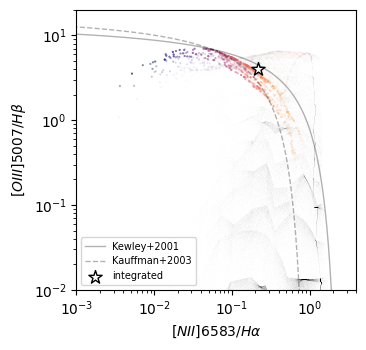

In [10]:
lines = intrinsic_lines
integrated_lines = integrated_intrinsic_lines

# lines = attenuated_lines
# integrated_lines = integrated_attenuated_lines

diagram = lines.get_diagram(diagram_id)
integrated_diagram = integrated_lines.get_diagram(diagram_id)


from matplotlib.colors import Normalize

# metallicity
cmap = cmr.get_sub_cmap('cmr.torch', 0., 0.85)
norm = Normalize(vmin=-3., vmax=-1.5)

colors = cmap(norm(np.log10(galaxy.stars.metallicities)))

fig = plt.figure(figsize=(3.5, 3.5))

bottom = 0.15
height = 0.8
left = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

# plot Kewley and Kauffmann lines 
for f, ls, limit, label in zip(
        [line_ratios.get_bpt_kewley01, line_ratios.get_bpt_kauffman03],
        ['-', '--'],
        [0.47, 0.05],
        ['Kewley+2001', 'Kauffman+2003']):
    log10x = np.arange(-5., limit, 0.01)
    ax.plot(10**log10x, 10**f(log10x), ls=ls, lw=1, c='k', alpha=0.3, label=label)


Ha_luminosity = lines[line_ratios.Ha].luminosity
Ha_luminosity /= np.max(Ha_luminosity)

ax.scatter(diagram[0], diagram[1], s=1, marker='.', c='k', alpha=0.005)
ax.scatter(diagram[0], diagram[1], s=1, marker='.', c=colors, alpha=Ha_luminosity)
ax.scatter(integrated_diagram[0], integrated_diagram[1], s=100, marker='*', c='w', edgecolors='k', label='integrated')
# ax.scatter(average_metallicity_diagram[0], average_metallicity_diagram[1], s=20, marker='h', c='w', edgecolors='k', label='integrated using average metallicity')

ax.legend(fontsize=7, loc='lower left')
ax.set_xlim([0.001, 4])
ax.set_ylim([0.01, 20])
ax.set_xscale('log')
ax.set_yscale('log')

xlabel, ylabel = lines.get_diagram_labels(diagram_id)

ax.set_xlabel(rf'${xlabel}$')
ax.set_ylabel(rf'${ylabel}$')

figname = f'figs/tng_bpt.png'
fig.savefig(figname)
plt.show()
fig.clf()

## Maps

#### Preliminaries

In [11]:
from scipy.stats import binned_statistic_2d
from matplotlib import cm

radius=15
bins=50
pixel_size = radius*2./bins # kpc
pixel_area = pixel_size**2
pixel_area_pc2 = pixel_area * 1000**2
print(pixel_area_pc2)

def add_weighted_histogram(ax, x, y, q, cmap_name='viridis', label=None, log10=False, vmin=0.0, vmax=None):

    if cmap_name.split('.')[0] == 'cmr':
        cmap = cmr.get_sub_cmap(cmap_name, 0, 1)
    else:
        cmap = cm.get_cmap(cmap_name)

    cmap.set_bad(color='0.5')

    range = [(-radius, radius),(-radius, radius)]

    hist, xedges, yedges = np.histogram2d(
        x, 
        y, 
        weights=q, 
        range=range, 
        bins=bins,)
    
    hist /= pixel_area_pc2

    if log10 is True:
        hist = np.log10(hist)

    # selection = hist == hist
    # if not vmin:
    #     vmin = np.min(hist[selection])
    if not vmax:
        if log10 is True:
            vmax = np.round(np.max(hist),1)+0.5
            vmin = vmax - 4.
        else:
            vmax = np.max(hist)
            vmin = 0.0

    # hist[hist==-np.inf] = vmin

    norm = Normalize(vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='top', orientation='horizontal', pad=0.0, fraction=0.2)

    cbar.set_label(label=label,fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    ax.imshow(hist, cmap=cmap, vmin=vmin, vmax=vmax)

    return ax 


def add_ratio(ax, x, y, q1, q2, cmap_name='viridis', label=None, log10=False, vmin=0.0, vmax=None):

    if cmap_name.split('.')[0] == 'cmr':
        cmap = cmr.get_sub_cmap(cmap_name, 0, 1)
    else:
        cmap = cm.get_cmap(cmap_name)

    cmap.set_bad(color='0.5')

    range = [(-radius, radius),(-radius, radius)]

    hist1, xedges, yedges = np.histogram2d(
        x, 
        y, 
        weights=q1, 
        range=range, 
        bins=bins,)
    
    hist2, xedges, yedges = np.histogram2d(
        x, 
        y, 
        weights=q2, 
        range=range, 
        bins=bins,)
    
    ratio = hist1/hist2

    if log10 is True:
        ratio = np.log10(ratio)

    if not vmax:
        if log10 is True:
            vmax = np.round(np.max(ratio),1)+0.5
            vmin = vmax - 4.
        else:
            vmax = np.max(ratio)
            vmin = 0.0

    norm = Normalize(vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='top', orientation='horizontal', pad=0.0, fraction=0.2)

    cbar.set_label(label=label,fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    ax.imshow(ratio, cmap=cmap, vmin=vmin, vmax=vmax)

    return ax 



def add_binned_statistic(fig, ax, x, y, q, cmap_name='viridis', statistic='median', label=None, log10=False, vmin=None, vmax=None):

    if cmap_name.split('.')[0] == 'cmr':
        cmap = cmr.get_sub_cmap(cmap_name, 0, 1)
    else:
        cmap = cm.get_cmap(cmap_name)

    cmap.set_bad(color='0.5')

    range = [(-radius, radius),(-radius, radius)]

    statistic, xedges, yedges, N = binned_statistic_2d(x, y, q, statistic=statistic, bins=bins, range=range)

    if log10 is True:
        statistic = np.log10(statistic)

    if not vmin:
        vmin = np.min(statistic)
    if not vmax:
        vmax = np.max(statistic)

    norm = Normalize(vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='top', orientation='horizontal', pad=0.0, fraction=0.2)

    cbar.set_label(label=label,fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    ax.imshow(statistic, cmap=cmap, vmin=vmin, vmax=vmax)

    return ax 

360000.0


### Hydrogen Line emission map

/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_34570/2044408971.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_34570/2044408971.py:84: RuntimeWarning: invalid value encountered in divide
  ratio = hist1/hist2
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_34570/2981636322.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


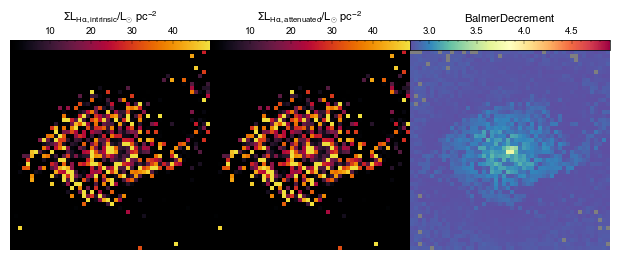

In [ ]:
lines = emergent_lines

N = 3
size = 2.

gridspec_kw = {'left': 0.0, 'right': 1.0, 'top': 1.0, 'bottom': 0.0, 'wspace': 0.0, 'hspace': 0.0 }

fig, axes = plt.subplots(1, N, gridspec_kw=gridspec_kw, figsize=(N*size, size*1.25))

for ax in axes:
    ax.axis('off')

# add stellar mass

intrinsic_Ha_luminosity = intrinsic_lines[line_ratios.Ha].luminosity.to('Lsun').value
attenuated_Ha_luminosity = emergent_lines[line_ratios.Ha].luminosity.to('Lsun').value


add_weighted_histogram(axes[0], x, y, intrinsic_Ha_luminosity, label=r'$\Sigma L_{H\alpha, intrinsic}/L_{\odot}\ pc^{-2}$', log10=False, cmap_name='cmr.ember', vmin = 0.1, vmax=49.)
add_weighted_histogram(axes[1], x, y, attenuated_Ha_luminosity, label=r'$\Sigma L_{H\alpha, attenuated}/L_{\odot}\ pc^{-2}$', log10=False, cmap_name='cmr.ember', vmin = 0.1, vmax=49.)

# add_weighted_histogram(axes[0], x, y, intrinsic_Ha_luminosity, label=r'$\log_{10}(\Sigma L_{H\alpha, intrinsic}/L_{\odot}\ pc^{-2})$', log10=True, cmap='cmr.ember', vmin = 0, vmax=1.5)
# add_weighted_histogram(axes[1], x, y, attenuated_Ha_luminosity, label=r'$\log_{10}(\Sigma L_{H\alpha, attenuated}/L_{\odot}\ pc^{-2})$', log10=True, cmap='cmr.ember', vmin = 0, vmax=1.5)

ratio = line_ratios.ratios['BalmerDecrement']
q1 = lines[ratio[0]].luminosity.value
q2 = lines[ratio[1]].luminosity.value
add_ratio(axes[2], x, y, q1, q2, label=r'$Balmer Decrement$', log10=False, cmap_name='Spectral_r', vmin=2.8, vmax=4.9)

fig.show()
fig.savefig('figs/tng_map_ha.png')
fig.savefig('figs/tng_map_ha.pdf')